In [37]:
import torch

def euclidean(x:torch.tensor, y:torch.tensor)->torch.tensor:
    return torch.sqrt(torch.pow(x-y,2)).sum()

def cos_sim(x:torch.tensor, y:torch.tensor)->torch.tensor:
    return x.view(-1).dot(y.view(-1)) / (torch.norm(x)*torch.norm(y))

In [38]:
import glob
import os
DATA_DIR = "/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train-and-experiment/data/lfw"

file_list = glob.glob(os.path.join(DATA_DIR,"*"))
sorted_list = sorted(file_list, key=lambda x: x.split("/")[-1])
print(sorted_list[0:5])
print()
print(file_list[0:5])
print()
print("the total number of IDs: ",len(file_list))

total_img = 0
more_than_two_img = 0
total_more_than_two_img = 0
data_path_list = []
for file in file_list:
    L = glob.glob(os.path.join(file, "*"))
    if len(L) > 1:
        data_path_list.append(L)
        total_img += len(L)
        total_more_than_two_img += len(L)
        more_than_two_img += 1
        # print(len(L))
        # print(L)
    else:
        total_img += 1

print("the number of images: ",total_img)
print("-"*50)
print("the number of IDs with more than one image: ",more_than_two_img)
print("the number of imagess with more than one image: ",total_more_than_two_img)
print(len(data_path_list))

['/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train-and-experiment/data/lfw/AJ_Cook', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train-and-experiment/data/lfw/AJ_Lamas', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train-and-experiment/data/lfw/Aaron_Eckhart', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train-and-experiment/data/lfw/Aaron_Guiel', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train-and-experiment/data/lfw/Aaron_Patterson']

['/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train-and-experiment/data/lfw/Emily_Mortimer', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train-and-experiment/data/lfw/Paul_Wellstone', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train-and-experiment/data/lfw/Tom_Gamboa', '/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train-and-experiment/data/lfw

In [39]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class Transforms:
    # normalize = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
    normalize = [[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]
    test_lfw = transforms.Compose([
        transforms.CenterCrop(112),
        # transforms.Resize((112,112)),
        transforms.ToTensor(),
        transforms.Normalize(*normalize)
    ])

class LFWMatchDataset(Dataset):
    def __init__(self, data_path_list, transform=None):
        self.data_paths = data_path_list
        self.transform = transform
    
    def __len__(self):
        return len(self.data_paths)
    
    def __getitem__(self, index):
        images = []
        for path in self.data_paths[index]:
            if self.transform:
                images.append(self.transform(Image.open(path)))
            else:
                images.append(Image.open(path))
        return {"images":images, "label":torch.tensor(index)}

In [40]:
test_set =  LFWMatchDataset(data_path_list,Transforms.test_lfw)

In [41]:
import torch
from model.iresnet import iresnet18

DIR = "/home/ljj0512/private/workspace/CV-project/Computer-Vision-Project/train-and-experiment/weights/baseline-finetune.pth"
model = iresnet18()
checkpoint = torch.load(DIR)
model.load_state_dict(checkpoint)

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


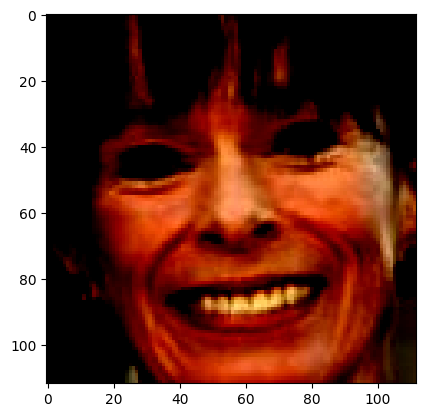

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


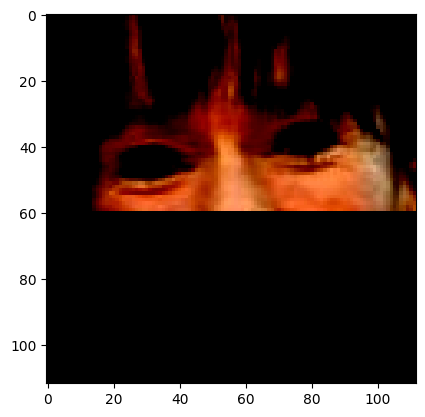

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


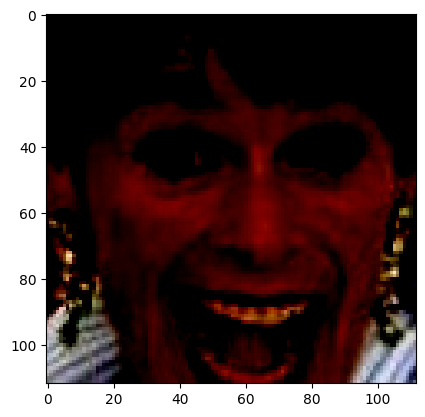

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


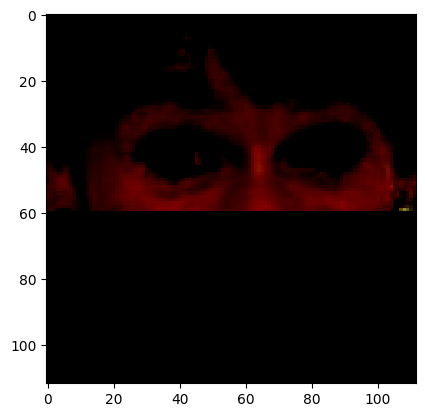

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


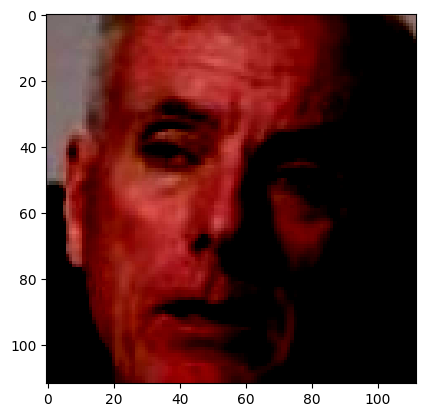

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


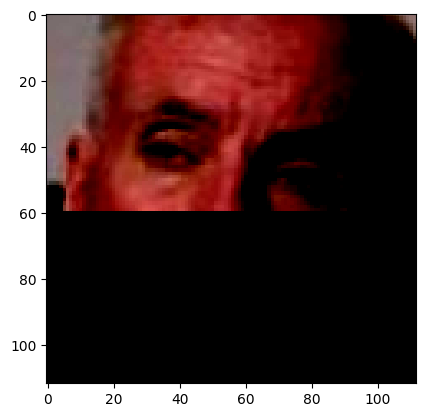

In [42]:
import random 
import matplotlib.pyplot as plt
from dataset import cutout_mask

model.eval()



with torch.no_grad():
    normal_vector_list = []

    ran1 = random.randint(0,1600)
    std_img = test_set[ran1]["images"]
    for i in range(2):
        temp = []
        img = std_img[i].clone()
        cut_img = cutout_mask(std_img[i].unsqueeze(0),p=1.).squeeze(0)
        temp.append(model(img.unsqueeze(0)).squeeze(0))
        temp.append(model(cut_img.unsqueeze(0)).squeeze(0))
        normal_vector_list.append(temp)
        plt.imshow(img.permute(1,2,0))
        plt.show()
        plt.imshow(cut_img.permute(1,2,0))
        plt.show()

    ran = random.randint(0,1600)
    while ran == ran1:
        ran = random.randint(0,1600)
    compar_img = test_set[ran]["images"]
    for i in range(1):
        temp = []
        img = compar_img[i].clone()
        cut_img = cutout_mask(compar_img[i].unsqueeze(0),p=1.).squeeze(0)
        temp.append(model(img.unsqueeze(0)).squeeze(0))
        temp.append(model(cut_img.unsqueeze(0)).squeeze(0))
        normal_vector_list.append(temp)
        plt.imshow(img.permute(1,2,0))
        plt.show()
        plt.imshow(cut_img.permute(1,2,0))
        plt.show()


In [43]:
print(cos_sim(normal_vector_list[0][0],normal_vector_list[1][0])) # no mask, no mask <= same
print(cos_sim(normal_vector_list[0][0],normal_vector_list[1][1])) # no mask, mask cutout <= same
print(cos_sim(normal_vector_list[0][1],normal_vector_list[1][0])) # mask cutout, no mask <= same
print(cos_sim(normal_vector_list[0][1],normal_vector_list[1][1])) # mask cutout, mask cutout <= same
print()
print(cos_sim(normal_vector_list[0][0],normal_vector_list[2][0])) # no mask, no mask <= diff
print(cos_sim(normal_vector_list[0][0],normal_vector_list[2][1])) # no mask, mask cutout <= diff
print(cos_sim(normal_vector_list[0][1],normal_vector_list[2][0])) # mask cutout, no mask <= diff
print(cos_sim(normal_vector_list[0][1],normal_vector_list[2][1])) # mask cutout, mask cutout <= diff
print()

tensor(0.5869)
tensor(0.3881)
tensor(0.4107)
tensor(0.5905)

tensor(0.1299)
tensor(0.0692)
tensor(0.0852)
tensor(0.1355)

